   X_mean  Y_mean  Z_mean    X_real    Y_real    Z_real  theta_ideal  \
0    0.60    0.25    0.20  0.560869  0.308909  0.364704     1.197482   
1    0.19    0.93    0.38  0.130827  0.926610  0.352532     1.210520   
2    0.11   -0.27    0.95  0.017643 -0.296353  0.954916     0.301421   
3    0.56    0.24    0.57  0.528451  0.183861  0.507396     0.772253   
4    0.27    0.25   -0.89  0.242608  0.371192 -0.896302     2.682156   

   phi_ideal   X_ideal   Y_ideal   Z_ideal     X_mle     Y_mle     Z_mle  \
0   0.338167  0.878389  0.308909  0.364704  0.600000  0.250000  0.200000   
1   1.430535  0.130827  0.926610  0.352532  0.185829  0.909582  0.371657   
2   4.771852  0.017643 -0.296353  0.954916  0.110000 -0.270000  0.950000   
3   0.395521  0.643882  0.268836  0.716341  0.560000  0.240000  0.570000   
4   0.991902  0.242608  0.371192 -0.896302  0.270000  0.250000 -0.890000   

   theta_mle   phi_mle  
0   1.369438  0.394791  
1   1.190003  1.369269  
2   0.317560 -1.183921  
3   0.9642

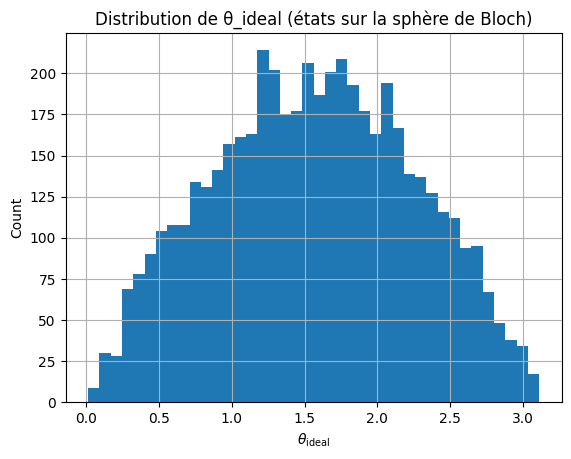

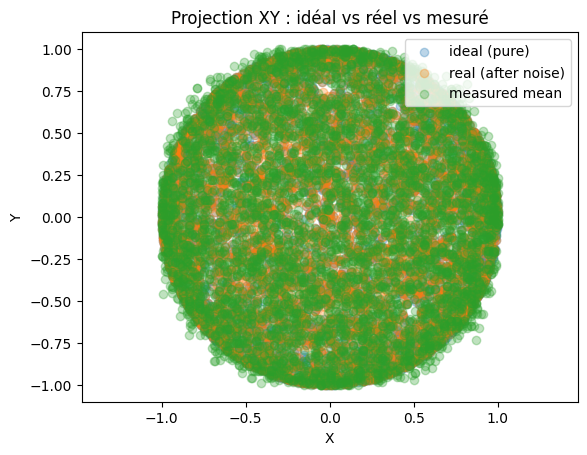

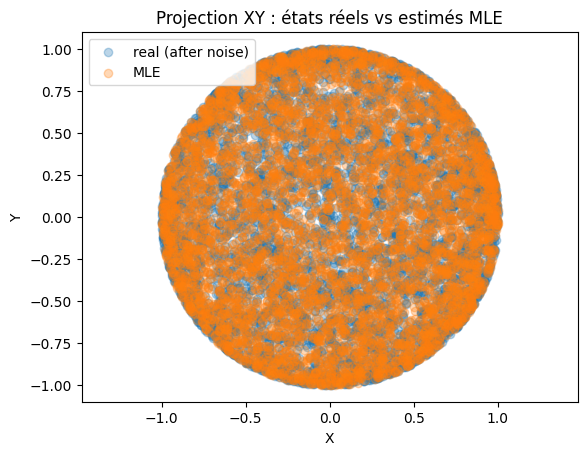

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# importer la fonction de création de dataset : 
from dataset_build.saint_dtSet import generate_qubit_tomography_dataset

# 1) Générer un dataset de test
df = generate_qubit_tomography_dataset(
    n_states=5000,
    n_shots=200,
    mode="finite_shots",
    include_ideal=True,
    include_mle=True,
    include_decoherence=True,    # test avec décohérence
    decoherence_level=0.3,
    random_state=123,
)

# 2) Afficher les premières lignes
print(df.head())

# 3) Quelques stats globales
print("\nDescription statistique des colonnes numériques :")
print(df.describe())

# 4) Plot de la distribution de θ_ideal (si include_ideal=True)
plt.figure()
df["theta_ideal"].hist(bins=40)
plt.xlabel(r"$\theta_{\mathrm{ideal}}$")
plt.ylabel("Count")
plt.title("Distribution de θ_ideal (états sur la sphère de Bloch)")
plt.show()

# 5) Scatter du vecteur de Bloch idéal vs réel vs mesuré (projection XY)
plt.figure()
plt.scatter(df["X_ideal"], df["Y_ideal"], alpha=0.3, label="ideal (pure)")
plt.scatter(df["X_real"], df["Y_real"], alpha=0.3, label="real (after noise)")
plt.scatter(df["X_mean"], df["Y_mean"], alpha=0.3, label="measured mean")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Projection XY : idéal vs réel vs mesuré")
plt.legend()
plt.axis("equal")
plt.show()

# 6) Scatter des points MLE vs état RÉEL sur la sphère (XY)
#    On filtre les lignes où la MLE n'est pas NaN
mask_valid_mle = df["theta_mle"].notna() & df["phi_mle"].notna()
df_valid = df[mask_valid_mle].copy()

# On utilise directement les composantes de Bloch MLE
X_mle_bloch = df_valid["X_mle"]
Y_mle_bloch = df_valid["Y_mle"]

plt.figure()
plt.scatter(df_valid["X_real"], df_valid["Y_real"], alpha=0.3, label="real (after noise)")
plt.scatter(X_mle_bloch, Y_mle_bloch, alpha=0.3, label="MLE")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Projection XY : états réels vs estimés MLE")
plt.legend()
plt.axis("equal")
plt.show()


In [3]:
# test_classification

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1) Générer un petit dataset pour la classification
df_clf = generate_qubit_tomography_dataset(
    n_states=2000,
    n_shots=50,                 # peu de shots -> bruit plus fort
    mode="finite_shots",
    include_ideal=True,         # on a besoin de Z_true pour construire les labels
    include_mle=False,          # pas nécessaire pour ce test
    include_decoherence=False,  # on coupe la décohérence pour commencer simple
    random_state=42,
)

# 2) Définir une target binaire à partir de Z_true :
#    1 si état dans l'hémisphère nord (Z_true >= 0), 0 sinon
df_clf["label"] = (df_clf["Z_real"] >= 0).astype(int)

# 3) Features : les moyennes mesurées
X = df_clf[["X_mean", "Y_mean", "Z_mean"]].values
y = df_clf["label"].values

# (Optionnel) si tu autorises des NaN plus tard (décohérence + missing),
# il faudra filtrer ici :
# mask = ~np.isnan(X).any(axis=1)
# X = X[mask]
# y = y[mask]

# 4) Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

# 5) Création et entraînement du modèle SVC
clf = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=0)
clf.fit(X_train, y_train)

# 6) Prédiction et évaluation
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy SVC : {acc:.3f}")
print("Matrice de confusion :")
print(cm)
print("\nClassification report :")
print(classification_report(y_test, y_pred))


Accuracy SVC : 0.940
Matrice de confusion :
[[298  13]
 [ 23 266]]

Classification report :
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       311
           1       0.95      0.92      0.94       289

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



L’objectif de cette section est d’évaluer la capacité d’un modèle de Machine Learning à extraire une propriété physique simple d’un état quantique à partir de mesures bruitées. Dans le cadre de la tomographie quantique, on souhaite en général reconstruire l’état réel du qubit, représenté par son vecteur de Bloch (X_real, Y_real, Z_real). Cependant, avant d’aborder cette tâche plus complexe de régression, il est utile de commencer par un problème plus simple : déterminer si l’état appartient à l’hémisphère nord ou à l’hémisphère sud de la sphère de Bloch.

Pour cela, on définit une étiquette binaire directement à partir de l’état réel simulé : label = 1 si Z_real ≥ 0, et 0 sinon. Cette propriété géométrique simple découle uniquement de l’état réel, c’est-à-dire l’état effectivement mesuré après bruit statistique et éventuellement bruit de canal. L’objectif de la classification est donc de prédire cette étiquette en utilisant uniquement les mesures brutes bruitées, à savoir les valeurs X_mean, Y_mean et Z_mean obtenues à partir d’un nombre limité de shots.

Ce test sert de validation préalable essentielle. S’il est impossible pour un modèle de classification de récupérer une propriété globale aussi simple que le signe de Z_real, il est illusoire d’espérer réussir une reconstruction complète du vecteur de Bloch réel via une régression plus fine. À l’inverse, si la classification réussit malgré le bruit statistique, cela montre que les features contiennent bien une partie exploitable de l’information physique.

En résumé, cette classification n’a pas pour but de résoudre la tomographie complète, mais de tester de manière contrôlée et progressive la capacité d’un modèle à extraire une information physique réelle à partir de mesures bruitées. Ce type d’analyse constitue une étape préparatoire logique avant de s’engager dans des tâches de reconstruction plus précises de l’état quantique.